#### Bruno Nadalic Sotic

11353473

Big Data and Automated Content Analysis

Final Assignment

## Abstract

This document presents the code and procedure for a research study investigating the predictability of song popularity on Spotify using the songs audio features and visual features derived from the songs cover images. The document is divided into two parts.

In the first part, the focus is on audio features. The process begins with authorizing an account and making API calls to retrieve data and audio features of popular and unpopular music. The dataset is then inspected for quality, handling missing values, duplicates, etc. Exploratory analysis is conducted through histograms to gain insights into the data and the relationship between variables. Correlations and VIF scores are calculated to identify potential multicollinearity issues. Based on these findings, three models (OLS, Random Forest, and XGBoost) are selected, trained, and evaluated for predicting popularity using audio features. The importance of features is also examined. Additionally, the possibility of treating the task as a binary classification is explored by training logistic regression and KNN models alongside the Random Forest (extracurricular task).

In the second part of the project, the focus shifts to predicting popularity classes based on features extracted from cover images of the tracks. A separate scraper is developed to collect said images. Visual features are then extracted using a CNN architecture, and their distributions across popularity classes are visualized. Finally, a Support Vector Classifier (SVC) model is trained to assess the classification performance in predicting popularity classes based on cover image features.

## Part 1

### Data Collection: Preliminaries and Authentication

In the research paper, the initial step involves loading the essential packages required for accessing Spotify's API. The data collection script employed in this study is based on the official Spotify documentation. To begin with, the developer account is established and authorized. Subsequently, an API call is made to retrieve an access token and authenticate it.

In [57]:
#preliminary packages
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import requests
import time

In [58]:
#set authorization details and response from api
client_id = '397ac9753d024265ba79512130601e88'
client_secret = 'f0cceed84fbb437d962a16c529c1100f'
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [59]:
#set token
access_token_url = "https://accounts.spotify.com/api/token"

# Fetch access token
auth_response = requests.post(access_token_url, {
    'grant_type': 'client_credentials',
    'client_id': client_id,
    'client_secret': client_secret,
})

access_token = auth_response.json()['access_token']

# Set up headers for API requests
headers = {
    'Authorization': f'Bearer {access_token}',
    'Content-Type': 'application/json'
}

### Finding the corpus and anti-corpus

The API operates on individual song or playlist IDs. Since the objective of this research is to identify predictive features of popular and unpopular music, the approach involves obtaining a sample of popular and unpopular music. When researching what features can predict the popularity of songs, it is wise to have a data collection approach that includes both popular and unpopular songs. Including a diverse range of songs across the popularity spectrum will provide a more comprehensive and representative dataset for analysis.

To achieve this, the Spotify API can be utilized to retrieve a list of playlist IDs that are currently considered popular or featured. Additionally, songs falling under the 'unknown' genre, which typically have fewer streams, can be included. Once the list of playlist IDs is obtained, manual inspection was performed to determine if the number of streams aligns with the categorization of popular or unpopular.

This methodology allows for the collection of relevant data for further analysis and examination of features associated with popular and unpopular music.

Retrieve a list of Spotify Playlist IDs that are considered popular:

In [60]:
pop_playlists = sp.featured_playlists(limit=10)

for playlist in pop_playlists['playlists']['items']:
    print(playlist['id'])

37i9dQZF1DWSBi5svWQ9Nk
37i9dQZF1DXdKMCnEhDnDL
37i9dQZF1DWVJyzEwVacEu
37i9dQZF1DXa6nwj9J2RnE
37i9dQZF1DX2fMaj5GfMh3
37i9dQZF1DX07sewTBuMpX
37i9dQZF1DWYSNbqvqvhBQ
37i9dQZF1DX6MUrG3NBYtM
37i9dQZF1DX2BCjruDQhfl
37i9dQZF1DX1rUSgDt83Z2


And now unpopular:

In [61]:
unpop_playlists = sp.search(q='%', type='playlist', limit=10)
for playlist in unpop_playlists['playlists']['items']:
    print(playlist['id'])

5kHmmDwHvrQfZa2uUGpHgb
3Pi8J1cWIigYSv7gB6tdPW
2SHypNarb9vu5bGtG5K7Ns
4Z7KtZqyykDmmelcLHtups
4IsD9J8rO2Ng2kf6wAx1zi
37i9dQZF1DXdNw9eeM3mpo
6XnT3ECPNV2KJeqJDABMj8
7GLiceIwGdBkC7nZQR4QIr
0ZQFMnsgERQ8d1364KQXHe
31yZRdlmwx7eTKyxCdcsd0


A limit has been se to 10 playlist ids. the Spotify API has a rate limit, which technically can be bypassed by introducing sleep in the script, however, the number of observations and cover images retrieved for more than 20 playlist would exceed the computational resources that I have.

### Part 1: Scraping Tracks & Audio Features

This script retrieves track information and audio features from a list of Spotify playlists. It sets a limit for the number of tracks to fetch per playlist and includes a delay between API requests to avoid rate limits.

The script iterates through each playlist ID in the provided list and fetches track data using the Spotify API. It then extracts relevant fields. To prevent exceeding the rate limit, the script includes a sleep function to introduce a delay of 1 second between each API request.

By default Spotify API returns all possible variables, HOwever, this would end up in more than 36 variables, and the resulting dataset would be in a nested json format. Variables relevant for this research have already been predefined, therefore, the script only extracts relevant information. It also does some of the cleaning already to have the dataset in tabular form. 

In [18]:
#list of playlist IDs
playlist_ids = [
    "5kHmmDwHvrQfZa2uUGpHgb",
    "3Pi8J1cWIigYSv7gB6tdPW",
    "2SHypNarb9vu5bGtG5K7Ns",
    "29TPKRyAEXqhFXauIFWYi5",
    "4Z7KtZqyykDmmelcLHtups",
    "37i9dQZF1DXdNw9eeM3mpo",
    "4IsD9J8rO2Ng2kf6wAx1zi",
    "5Iq5lkmYLYNLbECk9o9MYL",
    "7GLiceIwGdBkC7nZQR4QIr",
    "79k7Fv7vJZegErC8vO9WF1", 
    "37i9dQZF1DX9u7XXOp0l5L",
    "37i9dQZF1DXcx1szy2g67M",
    "37i9dQZF1DWSXWSaQmvWOB",
    "37i9dQZF1DWUX3x84bv557",
    "37i9dQZF1DXa6nwj9J2RnE",
    "37i9dQZF1DWYPwGkJoztcR",
    "37i9dQZF1DX2fMaj5GfMh3",
    "37i9dQZF1DWSBi5svWQ9Nk",
    "37i9dQZF1DXdKMCnEhDnDL",
    "37i9dQZF1DX73EtbU4jEcn"
]

# This function fetches track information and audio features for a given playlist ID
def fetch_tracks_from_playlist(playlist_id, limit=100, offset=0):
    results = sp.playlist_tracks(playlist_id, limit=limit, offset=offset)
    tracks = results['items']

    for track in tracks:
        track_info = track['track']
        track_id = track_info['id']
        audio_features = sp.audio_features([track_id])[0]
        
        # Extract the desired fields
        track_data = {
            'Track ID': track['track']['id'],
            'Track Name': track_info['name'],
            'Artist': track_info['artists'][0]['name'],
            'Popularity': track_info['popularity'],
            'Duration (ms)': track_info['duration_ms'],
            'Danceability': audio_features['danceability'],
            'Energy': audio_features['energy'],
            'Loudness': audio_features['loudness'],
            'Speechiness': audio_features['speechiness'],
            'Acousticness': audio_features['acousticness'],
            'Instrumentalness': audio_features['instrumentalness'],
            'Liveness': audio_features['liveness'],
            'Valence': audio_features['valence'],
            'Tempo': audio_features['tempo'],
        }
        
        track['track'] = track_data

    return tracks

# Fetch data from each playlist ID in the list
all_tracks = []
for playlist_id in playlist_ids:
    print(f"Fetching data for playlist: {playlist_id}")
    tracks = fetch_tracks_from_playlist(playlist_id, limit=100)  # API limit
    all_tracks.extend(tracks)
    time.sleep(1)  # To be safe and avoid hitting the rate limit

# Extract the track data from the nested structure
track_data = [track['track'] for track in all_tracks]

# Convert the track data to a DataFrame
df = pd.DataFrame(track_data)

# Save the DataFrame to a CSV file
df.to_csv('spotify_tracks_data_final.csv', index=False)

print(f"Data saved to csv.")

Fetching data for playlist: 5kHmmDwHvrQfZa2uUGpHgb
Fetching data for playlist: 3Pi8J1cWIigYSv7gB6tdPW
Fetching data for playlist: 2SHypNarb9vu5bGtG5K7Ns
Fetching data for playlist: 29TPKRyAEXqhFXauIFWYi5
Fetching data for playlist: 4Z7KtZqyykDmmelcLHtups
Fetching data for playlist: 37i9dQZF1DXdNw9eeM3mpo
Fetching data for playlist: 4IsD9J8rO2Ng2kf6wAx1zi
Fetching data for playlist: 5Iq5lkmYLYNLbECk9o9MYL
Fetching data for playlist: 7GLiceIwGdBkC7nZQR4QIr
Fetching data for playlist: 79k7Fv7vJZegErC8vO9WF1
Fetching data for playlist: 37i9dQZF1DX9u7XXOp0l5L
Fetching data for playlist: 37i9dQZF1DXcx1szy2g67M
Fetching data for playlist: 37i9dQZF1DWSXWSaQmvWOB
Fetching data for playlist: 37i9dQZF1DWUX3x84bv557
Fetching data for playlist: 37i9dQZF1DXa6nwj9J2RnE
Fetching data for playlist: 37i9dQZF1DWYPwGkJoztcR
Fetching data for playlist: 37i9dQZF1DX2fMaj5GfMh3
Fetching data for playlist: 37i9dQZF1DWSBi5svWQ9Nk
Fetching data for playlist: 37i9dQZF1DXdKMCnEhDnDL
Fetching data for playlist: 37i

Inspect the dataset:

In [66]:
df = pd.read_csv('spotify_tracks_data_final.csv')
df.head() #I know that saving our files as 'df' or something is undesirable, but old habbits die slow, and no way I will now change everyhting. Soryy haha

,Track ID,Track Name,Artist,Popularity,Duration (ms),Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo
0,6pD0ufEQq0xdHSsRbg9LBK,un x100to,Grupo Frontera,99,194563,0.569,0.724,-4.076,0.0474,0.228,0.000000,0.2700,0.562,83.118
1,3Gs7mVfWKl567mjozgxmXv,Niña Bonita,Feid,88,187653,0.823,0.615,-4.190,0.1470,0.104,0.000000,0.1040,0.470,90.952
2,2ec3eRB4zEYzuBl3cja0qA,ALGARETE,NATTI NATASHA,75,208549,0.779,0.641,-6.085,0.0745,0.229,0.003490,0.1090,0.452,90.034
3,3dnP0JxCgygwQH9Gm7q7nb,Ella Baila Sola,Eslabon Armado,100,165671,0.668,0.758,-5.176,0.0332,0.483,0.000019,0.0837,0.834,147.989
4,505v13epFXodT9fVAJ6h8k,AMARGURA,KAROL G,83,170480,0.920,0.696,-3.356,0.0742,0.183,0.000000,0.1490,0.545,106.966


### Exploration and Data Quality Checks

This part looks at the structure and describes the dataset on a basic level. It also perofrms quality checks, i.e., inspect and deal with missing values and duplicates.

In [7]:
print(f'The number of osbervations in the dataset: {len(df)}')

The number of osbervations in the dataset: 1596


In [67]:
# Check for missing values in each column
missing_values = df.isnull().sum()

print("Missing values per column:")
print(missing_values)

Missing values per column:
Track ID            0
Track Name          0
Artist              0
Popularity          0
Duration (ms)       0
Danceability        0
Energy              0
Loudness            0
Speechiness         0
Acousticness        0
Instrumentalness    0
Liveness            0
Valence             0
Tempo               0
dtype: int64


NExt is to check duplicates (since 1 track could be presenti in numerous playlists). Duplicates will be dropped from the dataset.

In [68]:
# Count duplicates in the specified column
duplicate_count = df.duplicated(subset=['Track ID']).sum()

print("Number of duplicates under 'ID' column:", duplicate_count)

Number of duplicates under 'ID' column: 104


In [69]:
#Drop duplicate rows based on the id column
df_clean = df.drop_duplicates(subset=['Track ID'])

In [70]:
print(f'after cleaning, the dataset has the following numnber of observations: {len(df_clean)}')

after cleaning, the dataset has the following numnber of observations: 1492


Now to make sure that the data types match.

In [71]:
df_clean.dtypes

Track ID             object
Track Name           object
Artist               object
Popularity            int64
Duration (ms)         int64
Danceability        float64
Energy              float64
Loudness            float64
Speechiness         float64
Acousticness        float64
Instrumentalness    float64
Liveness            float64
Valence             float64
Tempo               float64
dtype: object

The types seem to match the API documentation and waht I expect, next is to explore the distributions and ranges to decide if and which variables need to be transformed.

### Data Exploration and Distributions

#### DV: Popularity

The following inspects the main dependant variable of this research (popularity):

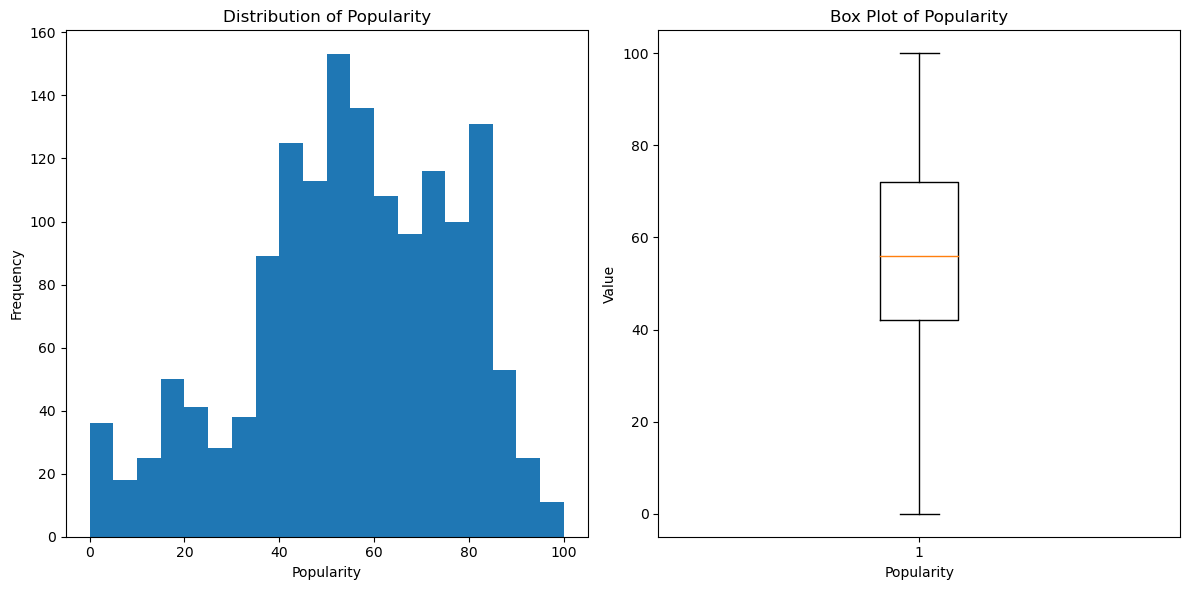

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
#reate subplots for histogram and box plot side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Histogram
ax1.hist(df_clean['Popularity'], bins=20)
ax1.set_xlabel('Popularity')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Popularity')

# Box plot
ax2.boxplot(df_clean['Popularity'])
ax2.set_xlabel('Popularity')
ax2.set_ylabel('Value')
ax2.set_title('Box Plot of Popularity')

fig.tight_layout()

# Display the plot
plt.show()

The main independant variable seems to have an adequate distribution. This confirms that the scraping strategy for obtaining a varried mix of popular and unpopular songs worked.

The next step visualizes the distributions for all other variables and biases / skewness are discussed.

#### All Variables

,Popularity,Duration (ms),Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo
count,1492.000000,1492.000000,1492.000000,1492.000000,1492.000000,1492.000000,1492.000000,1492.000000,1492.000000,1492.000000,1492.000000
mean,54.707775,212067.668231,0.661139,0.644786,-7.087983,0.093845,0.267860,0.023640,0.171589,0.553716,121.561242
std,21.895499,52402.201980,0.141502,0.193802,2.805988,0.097514,0.266983,0.105750,0.125376,0.243714,27.665917
min,0.000000,16400.000000,0.167000,0.051800,-20.461000,0.024400,0.000025,0.000000,0.022200,0.000000,50.658000
25%,42.000000,175422.000000,0.568750,0.511000,-8.491000,0.037075,0.039200,0.000000,0.092700,0.365000,99.320250
50%,56.000000,205492.500000,0.668000,0.674000,-6.645000,0.051500,0.176000,0.000005,0.122000,0.545000,121.937000
75%,72.000000,238969.000000,0.762000,0.798000,-5.116500,0.102250,0.430000,0.000323,0.217000,0.754250,137.924750
max,100.000000,519665.000000,0.972000,0.991000,-0.722000,0.957000,0.979000,0.945000,0.970000,0.976000,204.396000


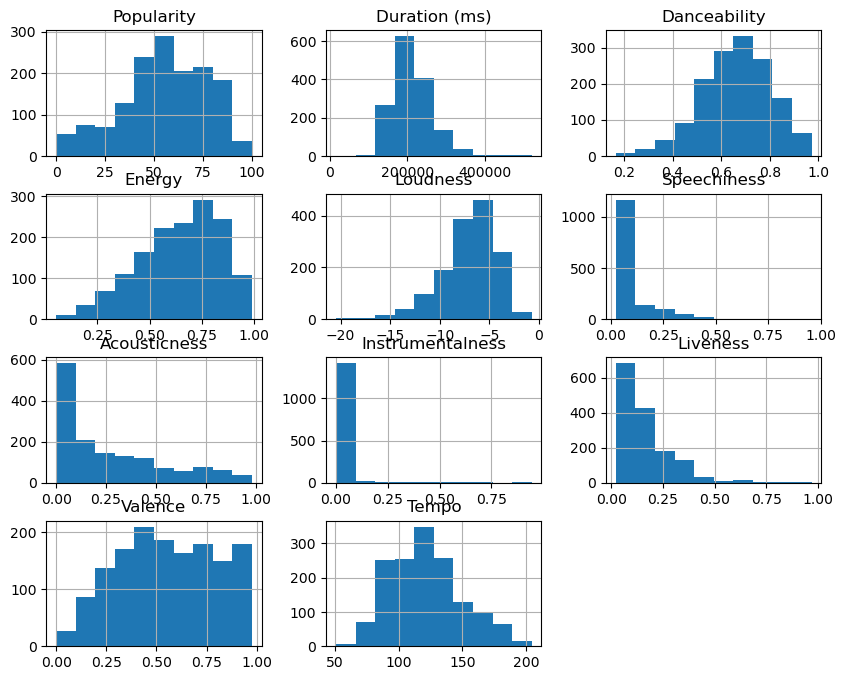

In [72]:
# Create histograms for all numerical variables
df_clean.hist(figsize=(10, 8))

df_clean.describe()

The average popularity score is 54.71, with a standard deviation of 21.90, indicating a wide range of popularity levels among tracks. Duration (measured in milliseconds) has a mean of 212,067.67 and a standard deviation of 52,402.20, featuring a minimum value of 16,400 and a maximum of 519,665. This suggests a possible positive skew in the duration distribution. Key and loudness have more distinct distributions, with keys ranging from 0 to 11 and loudness displaying a negative skew, as evidenced by a mean of -7.09 dB and a standard deviation of 2.81 dB.

Regarding other continuous variables, danceability, energy, and valence exhibit means and medians that are fairly close, indicating relatively symmetric distributions. However, speechiness, acousticness, instrumentalness, and liveness show positive skew, as their means are higher than their medians, and their maximum values are considerably larger compared to their 75th percentile values. Tempo has a mean of 121.56 BPM and a standard deviation of 27.67 BPM, suggesting a fairly wide range of tempos among the tracks. 

Finally, the mode and time signature variables are categorical, with mode mainly consisting of 0 or 1, and time signature primarily taking values between 1 and 5. Following Gulmatico et als. (2022) insights, those two variables have no relation with the dependant variables, and the authors suggest dropping them from the model to increase accuracy and reduce noise. 

#### Correlations

This part explores how the independatn variables relate to the dependant variable as well as among eachother. This is a crutial step to understand potential multicolinearity issues and insights are used to inform model selection. 

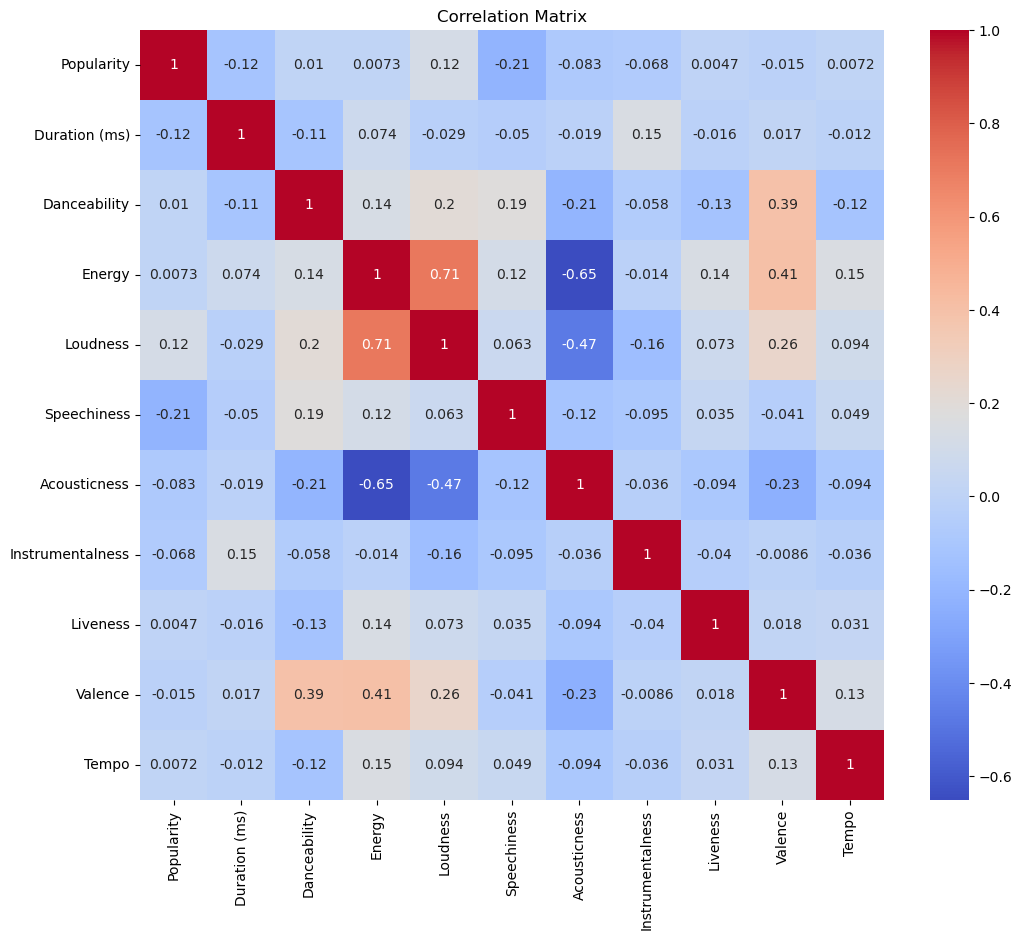

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select the variables for correlation
variables = ['Popularity', 'Duration (ms)', 'Danceability', 'Energy',
             'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness',
             'Liveness', 'Valence', 'Tempo']

# Subset the DataFrame with selected variables
df_subset = df_clean[variables]

# Compute the correlation matrix
correlation_matrix = df_subset.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

# Set the title of the plot
plt.title('Correlation Matrix')

# Display the plot
plt.show()

Speechiness seems to have a slight correlation with popularity, whereas the other variables exhibit very low coeficients. This might mean that the relationship between the variables might not be linear, or be even more complex. There are some correlations among the IVs. Therefore, the next steps calculates VIF scores to test for multicolinearity issues. 

In [37]:
import statsmodels.api as sm

# Subset the DataFrame with selected variables
df_subset = df_clean[variables]

# Function to calculate VIF
def calculate_vif(dataframe, variables):
    # Create a DataFrame to store the VIF results
    vif = pd.DataFrame()
    vif["Variable"] = variables
    vif["VIF"] = [sm.OLS(dataframe[var], sm.add_constant(dataframe.drop(var, axis=1))).fit().rsquared for var in variables]

    return vif

# Calculate VIF for the variables in df_subset
vif = calculate_vif(df_subset, variables)

# Print the VIF results
print(vif)

            Variable       VIF
0         Popularity  0.102446
1      Duration (ms)  0.062114
2       Danceability  0.308620
3             Energy  0.704541
4                Key  0.006601
5           Loudness  0.562043
6        Speechiness  0.146312
7       Acousticness  0.458059
8   Instrumentalness  0.080757
9           Liveness  0.050563
10           Valence  0.341928
11             Tempo  0.072616


Scores are well below 5. This hints that multicolienarity might not be of concern for this dataset. 

### Part 1: Modelling and Predictions

(Source reference for all of aprt 1: https://www.udemy.com/course/machinelearning/)

In order to investigate the predictability of song popularity based on audio features, three different models were employed and assessed. Firstly, a linear regression model was used as a baseline for comparison against the other models. Subsequently, a random forest regressor and an XGBoost model were trained, both known for their ability to handle non-linear relationships and outliers effectively. The models were trained on 80% of the dataset and evaluated on the remaining 20% using root mean absolute error (RMAE), root mean squared error (RMSE), and R-squared (R2) metrics. To optimize the performance of the XGBoost and random forest models, hyperparameters were fine-tuned using grid search and cross-validation.

#### Baseline Model

In [40]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Select the desired features
selected_features = ['Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Duration (ms)']
X = df_clean[selected_features]

# Assign the target variable
y = df_clean['Popularity']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define baseline model (Linear Regression)
baseline_model = LinearRegression()

# Fit the baseline model
baseline_model.fit(X_train, y_train)

# Make predictions using the baseline model
baseline_predictions = baseline_model.predict(X_test)

# Evaluate baseline model
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_predictions))
baseline_mae = mean_absolute_error(y_test, baseline_predictions)
ols_r2 = r2_score(y_test, baseline_predictions)

# Print baseline model performance
print("Baseline Model")
print("RMSE:", baseline_rmse)
print("MAE:", baseline_mae)
print("OLS R-squared:", ols_r2)


Baseline Model
RMSE: 19.87659068630231
MAE: 15.592458596307548
OLS R-squared: 0.09957869067025382


#### Rndom Forrest Model

In [41]:
# Define the Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Define hyperparameters to tune
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

# Perform Grid Search Cross Validation to find best hyperparameters
rf_grid_search = GridSearchCV(rf_model, param_grid=rf_param_grid, scoring='neg_mean_squared_error', cv=5)
rf_grid_search.fit(X_train, y_train)

# Get the best Random Forest model
best_rf_model = rf_grid_search.best_estimator_

# Make predictions using the best Random Forest model
rf_predictions = best_rf_model.predict(X_test)

# Evaluate Random Forest model
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)
# Print Random Forest model performance
print("\nRandom Forest Model")
print("Best Parameters:", rf_grid_search.best_params_)
print("RMSE:", rf_rmse)
print("MAE:", rf_mae)
print("Random Forest R-squared:", rf_r2)



Random Forest Model
Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
RMSE: 19.23622374715745
MAE: 15.185032219061132
Random Forest R-squared: 0.15666210544511971


#### XGBoost Model

In [42]:
# Define the XGBoost model
xgb_model = xgb.XGBRegressor(random_state=42)

# Define hyperparameters to tune
xgb_param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300]
}

# Perform Grid Search Cross Validation to find best hyperparameters
xgb_grid_search = GridSearchCV(xgb_model, param_grid=xgb_param_grid, scoring='neg_mean_squared_error', cv=5)
xgb_grid_search.fit(X_train, y_train)

# Get the best XGBoost model
best_xgb_model = xgb_grid_search.best_estimator_

# Make predictions using the best XGBoost model
xgb_predictions = best_xgb_model.predict(X_test)

# Evaluate XGBoost model
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_r2 = r2_score(y_test, xgb_predictions)

# Print XGBoost model performance
print("\nXGBoost Model")
print("Best Parameters:", xgb_grid_search.best_params_)
print("RMSE:", xgb_rmse)
print("MAE:", xgb_mae)
print("XGBoost R-squared:", xgb_r2)



XGBoost Model
Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}
RMSE: 19.7021449627048
MAE: 15.398429424068999
XGBoost R-squared: 0.11531432372108286


**Part 1: Sub-Conclusion**

Comparing the three models based on the RMSE and MAE metrics, a lower value indicates better performance, whereas the higher values for the R-squared indicate better performance.

The Random Forest Model performs slightly better than the Baseline Model and XGBoost Model in terms of both RMSE and MAE. It achieves the lowest RMSE (19.236) and MAE (15.185) among the three models.

The Baseline Model has the highest RMSE (19.877) and MAE (15.592) values, indicating a weaker performance compared to the other two models.

The XGBoost Model falls in between the Baseline Model and the Random Forest Model in terms of performance. Although it has a lower RMSE (19.702) than the Baseline Model, the Random Forest Model outperforms it in terms of both RMSE and MA. 

The same conclusions can be drawn from the R2 values.

Next, an audit is conducted to asses what features contribute to what extent to the predictions for the best performing model.

#### Feature Importance

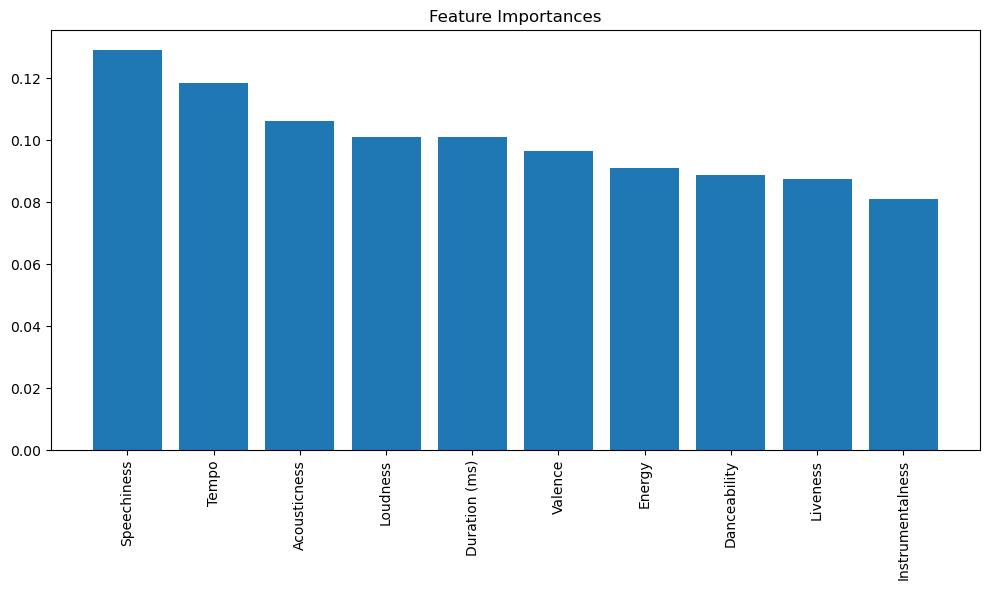

In [49]:
from sklearn.ensemble import RandomForestRegressor
# Get the feature importances
importances = rf.feature_importances_

# Get the feature names
feature_names = X.columns

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()

The bar graph represents the features on the x-axis and their corresponding feature importance scores on the y-axis. The feature importance scores indicate the relative importance of each feature in predicting the popularity of a song.
According to the graph, speechiness (the level of vocal content), tempo (the speed or rhythm), and acousticness (the degree of acoustic elements) are the most influential features in determining popularity, as they have the highest importance scores, with values above 0.10.
Loudness and duration have similar importance scores, followed by valence (the musical positiveness), danceability, and energy, which show a slight decline in importance.
The features that contribute the least to predicting popularity are liveness and instrumentalness. However, it is worth noting that even these features have importance scores greater than 0.08. Overall, while some features have a higher importance than others, the differences between the importance scores are not extremely large.


#### EXTRA EXPLORATION: KNN and Logistic Regression

This an extracurricular exploration. Previously, popularity ranges from 0 to 100 (as set by Spotify), but  predicting song popularity can also be approached as a binary classification task, wherein the popularity variable is operationalized into two distinct groups: popular and unpopular. The division between these two groups is determined based on the mean value of the popularity variable, which ranges from 0 to 100 as provided by Spotify's API.

Treating song popularity as a binary classification task is based on Reddy et als. (2021) work who argued that this allows us to simplify the prediction problem and provide a clear distinction between popular and unpopular songs. By establishing a threshold (mean popularity value) that separates these two groups, we can assign a binary label to each song based on its popularity level. This might increase the predictability of a model. Three seperate models are trained that are suitable for binary classification tasks, namely: Random Forrest Classifier, KNN and a Logistic Regression. 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


# Compute the mean of the 'Popularity' column
popularity_mean = df_clean['Popularity'].mean()

# Create the 'popularity label' variable based on the mean
df_clean.loc[:, 'Popularity Label'] = df_clean['Popularity'].apply(lambda x: 1 if x > popularity_mean else 0)

# Plot the distribution of the 'Popularity Label' variable
plt.figure(figsize=(6, 4))
sns.countplot(x='Popularity Label', data=df_clean)
plt.xlabel('Popularity Label')
plt.ylabel('Count')
plt.title('Distribution of Popularity Label')
plt.show()

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression # I know i probably have these packages lodade already, but given that i am working on this over a week, i really can be bothered going back and checking xD
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Select the desired features
selected_features = ['Duration (ms)', 'Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo']
X = df_clean[selected_features]

# Assign the target variable
y = df_clean['Popularity Label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the classifiers
knn = KNeighborsClassifier()
logreg = LogisticRegression()
rf = RandomForestClassifier()

# Train and evaluate the KNN classifier
knn.fit(X_train, y_train)
knn_predictions = knn.predict(X_test)
knn_report = classification_report(y_test, knn_predictions)

# Train and evaluate the Logistic Regression classifier
logreg.fit(X_train, y_train)
logreg_predictions = logreg.predict(X_test)
logreg_report = classification_report(y_test, logreg_predictions)

# Train and evaluate the Random Forest classifier
rf.fit(X_train, y_train)
rf_predictions = rf.predict(X_test)
rf_report = classification_report(y_test, rf_predictions)

# Print the classification reports
print("KNN Classifier Report:")
print(knn_report)
print("Logistic Regression Classifier Report:")
print(logreg_report)
print("Random Forest Classifier Report:")
print(rf_report)


C:\Users\sotic\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\sotic\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sotic\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-d

KNN Classifier Report:
              precision    recall  f1-score   support

           0       0.46      0.39      0.42       145
           1       0.49      0.56      0.53       154

    accuracy                           0.48       299
   macro avg       0.47      0.48      0.47       299
weighted avg       0.48      0.48      0.47       299

Logistic Regression Classifier Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       145
           1       0.52      1.00      0.68       154

    accuracy                           0.52       299
   macro avg       0.26      0.50      0.34       299
weighted avg       0.27      0.52      0.35       299

Random Forest Classifier Report:
              precision    recall  f1-score   support

           0       0.61      0.58      0.59       145
           1       0.62      0.65      0.63       154

    accuracy                           0.62       299
   macro avg       0.61      0.61

Treating it as a classification task, unsurprisingly, increases the accuracy (with the best performing one being the Random Forrest again). However, the accuracy scores are still not on a desired level. This could be enhanced in future research by fine-tuning the models.

## Part 2: Extracting Features from Images to predict Popularity

(Source reference: https://www.coursera.org/learn/introduction-computer-vision-watson-opencv)

The 2nd question of this research is to see if features derived from cover images of the spotify songs can be used to for popularity prediction / classification. To this end, data collection is again base don the Spotify API. The goal is to retrieve the cover images for each of the songs in the original dataset. 

### Data collection

The scraper begins by creating a new folder to store the cover images. The code then iterates over the tracks in the database and checks if the track has a cover image available. If a cover image is found, it is downloaded and saved in the designated folder. The code also handles cases where a cover image is not available or encounters errors while retrieving the image. To avoid overwhelming the server with requests, there is a delay between batches of requests. Once all the tracks have been processed, a message is printed to indicate the completion of the cover image collection.

In [66]:
# Create a new folder to store cover images
os.makedirs('spotify_images', exist_ok=True)

# Set the delay time (in seconds) between requests
delay = 1

# Set the batch size for processing
batch_size = 50

# Iterate over the tracks in your database and download cover images
for i, (index, row) in enumerate(df_clean.iterrows()):
    track_id = row['Track ID']
    track_info = sp.track(track_id)
    if 'images' in track_info['album'] and len(track_info['album']['images']) > 0:
        cover_url = track_info['album']['images'][0]['url']
        if cover_url:
            response = requests.get(cover_url)
            if response.status_code == 200:
                image_path = f'spotify_images/{track_id}.jpg'
                with open(image_path, 'wb') as file:
                    file.write(response.content)
                print(f"Downloaded cover image for track {track_id}") #followed advice and added print statements because my script was getting stuck
            else:
                print(f"Failed to retrieve image for track {track_id}")
        else:
            print(f"No cover image URL available for track {track_id}")
    else:
        print(f"No cover image available for track {track_id}")
    
    # Delay between requests
    if (i + 1) % batch_size == 0:
        print(f"Processed {i+1} tracks. Waiting for {delay} seconds...")
        time.sleep(delay)

# Print a message when image collection is complete
print("Cover images collection completed!")

Downloaded cover image for track 6pD0ufEQq0xdHSsRbg9LBK
Downloaded cover image for track 3Gs7mVfWKl567mjozgxmXv
Downloaded cover image for track 2ec3eRB4zEYzuBl3cja0qA
Downloaded cover image for track 3dnP0JxCgygwQH9Gm7q7nb
Downloaded cover image for track 505v13epFXodT9fVAJ6h8k
Downloaded cover image for track 2UW7JaomAMuX9pZrjVpHAU
Downloaded cover image for track 1SkYE3JjQ8wrwpeX6bmSEx
Downloaded cover image for track 5ww2BF9slyYgNOk37BlC4u
Downloaded cover image for track 6G12ZafqofSq7YtrMqUm76
Downloaded cover image for track 0PB0O24JqAuNdOAFVJljMS
Downloaded cover image for track 2oMjKuKUEJFuLiVmTq7Vjx
Downloaded cover image for track 4JdSXF2p71cr8uCY3UiJM0
Downloaded cover image for track 5upurRlqfBpopBHBahUu2n
Downloaded cover image for track 1zsPaEkglFvxjAhrM8yhpr
Downloaded cover image for track 3Zyk5Vd9WNPNVWxvb0EZTk
Downloaded cover image for track 4XqXNU8MwPHwbgZmNXmAdc
Downloaded cover image for track 39U5DHTTvKNX7o9lyJmBpl
Downloaded cover image for track 4fSIb4hdOQ151TI

### Image Feature Extraction

Now, set of cover images is processed to extract features using the VGG16 model. The VGG16 model is a deep convolutional neural network architecture that has been widely used for image classification tasks. It was chosen for this task because it has demonstrated excellent performance on various image-related tasks and has been pre-trained on a large dataset, making it capable of extracting meaningful features from the cover images.

The code iterates over the tracks in the dataset and loads the corresponding cover images. These images are then preprocessed, including resizing, converting to arrays, and applying necessary reshaping and preprocessing steps. The VGG16 model, which has been pre-trained on the ImageNet dataset, is utilized to extract features from the preprocessed images. The extracted features are stored for further analysis or modeling tasks.

In [20]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt


The code firslty iterates through the cleaned dataframe (df_clean) and load the cover images corresponding to each track ID. The images and their respective popularity labels are stored in in the the cover_images and popularity_labels lists.

In [21]:
cover_images = []
popularity_labels = []

for index, row in df_clean.iterrows():
    track_id = row['Track ID']
    image_path = f'spotify_images/{track_id}.jpg'
    try:
        image = Image.open(image_path)
        cover_images.append(image)
        popularity_labels.append(row['Popularity Label'])
    except:
        print(f"failed to load image for track {track_id}")


Next step is to preprocess these images by resizing them to the required input shape of the VGG16 model (224, 224), converting them to NumPy arrays, ensuring that they have three channels (RGB), and applying the VGG16-specific preprocessing function.

In [22]:
def preprocess_images(images):
    processed_images = []
    for image in images:
        # Resize the image to (224, 224) as expected by VGG16
        image = image.resize((224, 224))
        # Convert the image to an array of shape (224, 224, 3)
        image = np.array(image)
        # Check if the image has 3 channels, and reshape if necessary
        if image.shape[-1] != 3:
            image = np.stack((image,) * 3, axis=-1)
        # Preprocess the image using the VGG16 preprocessing function
        image = preprocess_input(image)
        processed_images.append(image)
    return np.array(processed_images)
preprocessed_images = preprocess_images(cover_images)


Next step is to extract features from these preprocessed images using the pre-trained VGG16 model. The code uses the model with the top layers removed (using include_top=False) and apply global average pooling (pooling='avg') to obtain a fixed-size feature vector for each image.

In [23]:
def extract_features(images):
    model = VGG16(weights='imagenet', include_top=False, pooling='avg')
    features = model.predict(images)
    return features

image_features = extract_features(preprocessed_images)

47/47 [==============================] - 450s 10s/step


The features are sepetrated into groups based on popularity. Then the t-distributed Stochastic Neighbor Embedding (t-SNE) algorithm is sued to to visualize the features of popular and unpopular songs in two dimensions. This helps us visually assess whether there is any separation between the two groups of features. - tsne is a dimensionality reduction technique that maps high-dimensional data to a 2D or 3D space, preserving the local structure of the data.

In [27]:
popular_features = image_features[np.array(popularity_labels) == 1]
unpopular_features = image_features[np.array(popularity_labels) == 0]

C:\Users\sotic\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

C:\Users\sotic\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



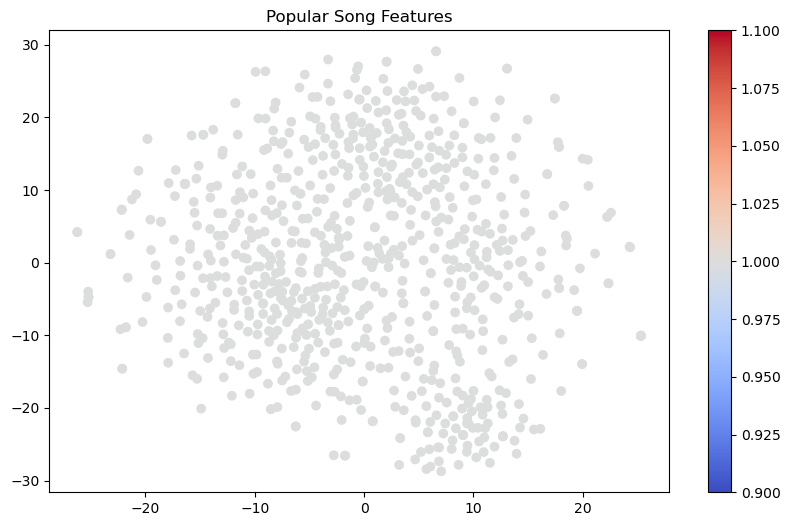

C:\Users\sotic\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

C:\Users\sotic\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



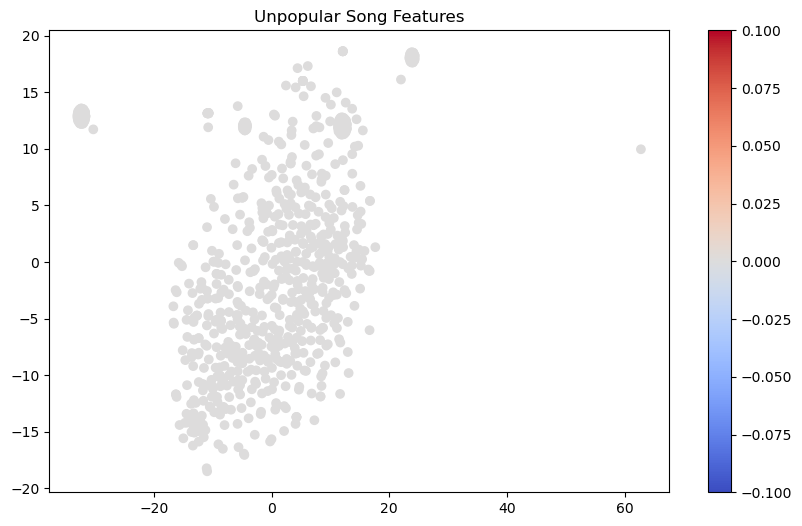

In [94]:
from sklearn.manifold import TSNE

def visualize_features(features, labels, title):
    tsne = TSNE(n_components=2, random_state=42)
    transformed_features = tsne.fit_transform(features)

    plt.figure(figsize=(10, 6))
    plt.scatter(transformed_features[:, 0], transformed_features[:, 1], c=labels, cmap='coolwarm')
    plt.colorbar()
    plt.title(title)
    plt.show()

visualize_features(popular_features, np.ones(len(popular_features)), 'Popular Song Features')
visualize_features(unpopular_features, np.zeros(len(unpopular_features)), 'Unpopular Song Features')

In [28]:
from sklearn.manifold import TSNE

def visualize_features(features, labels, title):
    tsne = TSNE(n_components=2, random_state=42)
    transformed_features = tsne.fit_transform(features)

    plt.figure(figsize=(10, 6))
    plt.scatter(
        transformed_features[labels == 1, 0],
        transformed_features[labels == 1, 1],
        c='red',
    )
    plt.scatter(
        transformed_features[labels == 0, 0],
        transformed_features[labels == 0, 1],
        c='blue',
    )
    plt.colorbar()
    plt.title(title)
    plt.legend()
    plt.show()


C:\Users\sotic\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\sotic\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


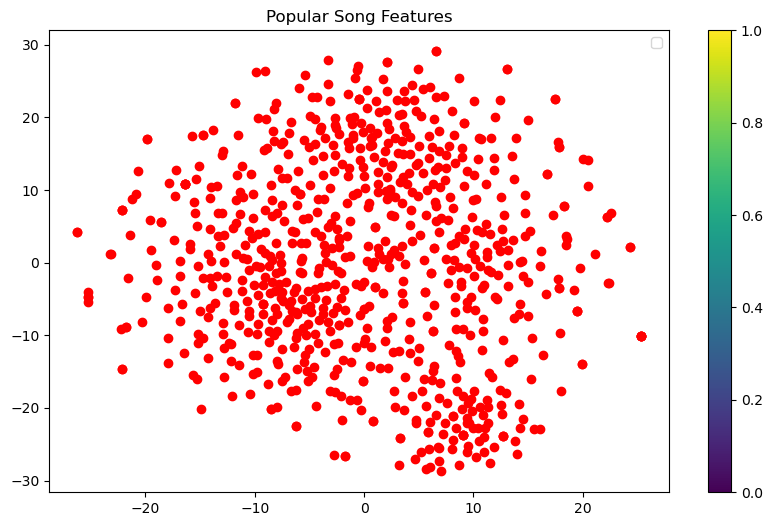

In [29]:
# Call the visualize_features function for popular songs
visualize_features(popular_features, np.ones(len(popular_features)), 'Popular Song Features')

C:\Users\sotic\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\sotic\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


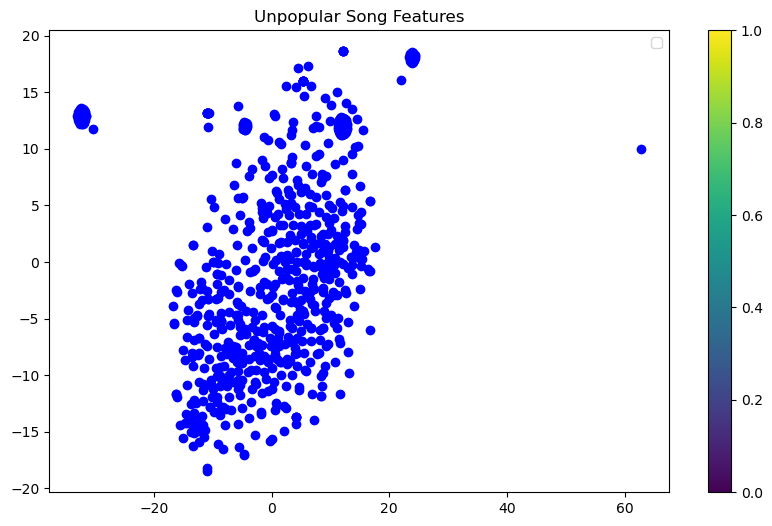

In [30]:
# Call the visualize_features function for unpopular songs
visualize_features(unpopular_features, np.zeros(len(unpopular_features)), 'Unpopular Song Features')

The scatter plots reveals that the popular songs' features are scattered all over the plot, filling out every angle. This suggests that the features of popular songs exhibit a wide range of values and do not cluster tightly together. On the other hand, the features of unpopular songs are more concentrated and tend to cluster on the left-mid side of the plot. The presence of bigger clusters indicates that there are distinct subsets of unpopular songs that share similar feature patterns. It shows that popular songs have a wider range of visual features, while unpopular songs tend to have more consistent patterns in their visual features.

The next step involves training a Support Vector Machine model to see if we can classify songs into poopularity categories based on the features derived form the images. 

### Classification Model

Classification is treated as a binary classification task. The SVM model is trained on the features derived from the images, then we test how the model performs in classifying the two popularity groups. First, the features derived from the images are scaled so that they fit with the requirements of the SVM model. The model is evaluated using the accuracy score and classification report. 

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report


# Scale the image features to otimize for SVM
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(image_features)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_features, popularity_labels, test_size=0.2, random_state=42)

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Create and train the SVM classifier
classifier = SVC()
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

#Evaluation
classification_rep = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_rep)


Accuracy: 0.5886287625418061
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.42      0.50       145
           1       0.58      0.75      0.65       154

    accuracy                           0.59       299
   macro avg       0.59      0.58      0.57       299
weighted avg       0.59      0.59      0.58       299



The SVM model for predicting song popularity based on image features achieved an accuracy of 0.5886, indicating that the model correctly classified approximately 58.86% of the songs in the dataset.

The classification report provides additional evaluation metrics for the model's performance:

Precision is the ratio of true positive predictions to the total number of positive predictions made by the model. For the unpopular class (0), the precision is 0.61, which means that 61% of the songs predicted as unpopular by the model were actually unpopular. For the popular class (1), the precision is 0.58, indicating that 58% of the songs predicted as popular were truly popular.

Recall, also known as sensitivity or true positive rate, is the ratio of true positive predictions to the total number of actual positive instances in the dataset. The recall for the unpopular class (0) is 0.42, indicating that the model identified 42% of the actual unpopular songs. The recall for the popular class (1) is 0.75, meaning that the model captured 75% of the actual popular songs.

The F1-score is the harmonic mean of precision and recall, providing a balanced measure of the model's performance. For the unpopular class (0), the F1-score is 0.50, while for the popular class (1), the F1-score is 0.65. These scores consider both precision and recall, providing a summary of the model's overall effectiveness for each class.

Support represents the number of samples in each class. In this case, there were 145 songs in the unpopular class (0) and 154 songs in the popular class (1).

Considering the macro average, which calculates the average of precision, recall, and F1-score across both classes, the model achieved an average precision, recall, and F1-score of approximately 0.59. The weighted average takes into account the support of each class and provides a weighted average of precision, recall, and F1-score, yielding similar results of approximately 0.59.